<a href="https://colab.research.google.com/github/MiguelRochaBE/MotorImagery-BCI/blob/master/MI_BCI_DatasetAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Conexão ao Google Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


## **Extrair base de dados do ficheiro zip**

Link: https://physionet.org/content/eegmmidb/1.0.0/

In [2]:
# !unzip -u "/content/drive/MyDrive/B(i)onitos/files.zip" -d "/content/drive/MyDrive"

## **Listar todos os ficheiros da base de dados**

In [3]:
import os

def run_fast_scandir(dir, ext):    # dir: str, ext: list
    subfolders, datafiles = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext:
                datafiles.append(f.path)

    for dir in list(subfolders):
        sf, f = run_fast_scandir(dir, ext)
        subfolders.extend(sf)
        datafiles.extend(f)
    return subfolders, datafiles


subfolders, datafiles = run_fast_scandir('/content/drive/MyDrive/files', [".edf"])
#subfolders, eventfiles = run_fast_scandir('/content/drive/MyDrive/files', [".event"])

subfolders.sort()
datafiles.sort()
print(subfolders[:3])
print(datafiles[:3])


['/content/drive/MyDrive/files/S001', '/content/drive/MyDrive/files/S002', '/content/drive/MyDrive/files/S003']
['/content/drive/MyDrive/files/S001/S001R01.edf', '/content/drive/MyDrive/files/S001/S001R02.edf', '/content/drive/MyDrive/files/S001/S001R03.edf']


## **Biblioteca MNE: https://mne.tools/stable/index.html**


In [4]:
!pip install mne
import mne
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Desenhar filtro passa-banda**

Extracting EDF parameters from /content/drive/MyDrive/files/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 529 samples (3.306 sec)



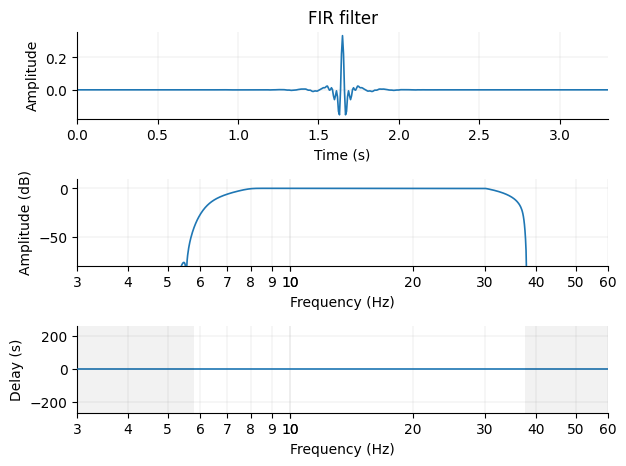

In [5]:
mne.set_log_level('INFO') #  Suprimir os logs das funções da biblioteca/ it can be either DEBUG, INFO, WARNING, ERROR, or CRITICAL

fmin = 8.
fmax = 30.
filter_design = 'firwin2'
ska = 'edge'

raw = mne.io.read_raw_edf(datafiles[0], preload = False)
channels = raw.ch_names
n_channels = len(channels)

filter_params = mne.filter.create_filter(raw.get_data(), raw.info['sfreq'],l_freq=fmin, h_freq=fmax, fir_design = filter_design) # Criar filtro. É preciso dados como parâmetro
mne.viz.plot_filter(filter_params, raw.info['sfreq'], flim=(3, 60)) # Plot do filtro

mne.set_log_level('WARNING')

* Não há **delay** no filtro, ou seja, a fase do sinal em todas as frequências permance a mesma. Isto refere-se ao facto de certos filtros provocarem pequenos desvios na fase do sinal, o que levaria a que o instante em que é dada a 'cue' visual para o participante mover determinado membro deixasse de ficar sincronizado com o sinal do EEG, podendo interferir com as janelas de tempo das features de interesse.

* Outro aspeto importante é o filtro ser **FIR** e não **IIR**. Os filtros **IIR**, apesar de apresentarem bandas de transição inferiores, isto é, a transição entre as frequências que se querem manter e as frequências que se querem retirar ser mais íngreme, estes também são mais instáveis que os filtros **FIR**. Mais importante ainda, os filtros **IIR** apresentam desvios de fase não lineares, ou seja, a mudança de fase não é a mesma em todas as frequências, provocando desvios no sinal que são difícies de controlar. Já nos filtro **FIR**, o desvio na fase é linear sendo possível compensá-lo e anulá-lo muito mais facilmente, sendo computacionalmente mais eficiente fazê-lo e com erro nulo sabendo o valor deste desvio. Isto geralmente é feito automaticamente.

* O *filter_desing* é o *firwin* e não *firwin2* porque o primeiro apresenta menos amostras e possui um resultado quase idêntico. Isto será importante durante o processamento em tempo real dos nossos sinais.

## **Ler dados e separar/agrupar os blocos de EEG consoante o tipo/classe de movimento**

**Descrição dos eventos da base de dados:**

Each annotation includes one of three codes (T0, T1, or T2):

- T0 corresponds to rest
- T1 corresponds to onset of motion (real or imagined) of the left fist (in runs 3, 4, 7, 8, 11, and 12) both fists and (in runs 5, 6, 9, 10, 13, and 14)
- T2 corresponds to onset of motion (real or imagined) of the right fist (in runs 3, 4, 7, 8, 11, and 12) and both feet (in runs 5, 6, 9, 10, 13, and 14)

In [6]:
def check_event_count(event_data):

  '''
  Função que:
  - Faz prints do número de trials/blocos de cada classe de movimento. 

  ---------------------
  Input:
  - event_data: Objeto com todos os blocos de dados

  '''

  print("Rest: ", event_data["rest"].__len__())
  print("Right Fist: ", event_data["right_fist"].__len__())
  print("Left Fist: ", event_data["left_fist"].__len__())
  print("Both Fists: ", event_data["both_fists"].__len__())
  print("Both Feet: ", event_data["both_feet"].__len__())

In [7]:
''' Commit "Test/Train split: 84144ec" tem todo o código com os prints e plots desta função relacionados com os eventos'''

def load_subject_data(subject, datafiles, tstart, tstop):

  '''
  Função que:
  - Carrega todos os dados contínuos de um participante da base de dados.
  - Filtra os dados contínuos.
  - Reatribui as labels para separar melhor as 5 classes de EEG da base de dados.
  - Agrupa e concatena os blocos dados dos vários trials (bloco com cerca de 4.2s de dados que 
  corresponde à execução de uma classe de movimento) de ficheiros 
  diferentes a partir das novas labels.
  - Segmenta os dados 

  ---------------------
  Input:
  subject: Caminho para o diretório onde estão todos os ficheiros de um participante 
  datafiles: Caminhos de todos os ficheiros edf (todos os participantes) da base de dados
  tstart: Instante no tempo (s) da primeira amostra do segmento de um bloco a ser analisado
  tstop: Instante no tempo (s) da última amostra do segmento de um bloco a ser analisado
  
  ---------------------
  Output:
  subject_epochs: Objeto com todos os blocos de dados concatenados e com toda a informção relativamente
  aos eventos de cada classe
  '''

  trials = []
  for trial in datafiles: 
    if subject in trial: 
      trials.append(trial)
  
  all_trials = [] # Variável com todos os blocos
  
  for count, trial  in enumerate(trials):
    if count > 1: # Avança os dois primeiros trials correspondentes ao rest
      raw_data = mne.io.read_raw_edf(trial, preload = True) # Dados EEG para um trial específico. 'Preload=True' serve para colocar o ficheiro na memória e não apenas referenciá-lo no diretório
      
      filtered_data = raw_data.copy().filter(fmin, fmax, fir_design=filter_design, skip_by_annotation=ska) # Filtrar os dados

      ch_names = filtered_data.ch_names # Elétrodos
      fs =  filtered_data.info.get('sfreq') # Frequência de amostragem
      annotations = filtered_data.annotations # Variável que contém os dados no tempo relativos aos blocos de movimentos executados
      
      trial_type1 = [3, 4, 7, 8, 11, 12]
      trial_type2 = [5, 6, 9, 10, 13, 14]

      # Atribuição das labels corretas aos eventos de cada trial

      trial_number = int(trial.split('.')[0][-2:]) # De 1 a 14; [0] corresponde à primeira parte da string original;
      
      if trial_number in trial_type1:
        event_ids = {'T0': 1, 'T1': 2, 'T2': 3} # Dicionário com os ids dos eventos de acordo com a descrição a laranja ^^
        epoch_event_ids = {"rest/block": 1, "left_fist/block": 2, "right_fist/block": 3}
      elif trial_number in trial_type2:
        event_ids = {'T0': 1, 'T1': 4, 'T2': 5}
        epoch_event_ids = {"rest/block": 1, "both_fists/block": 4,"both_feet/block": 5}
      else:
        event_ids = {'T0': 1} # Dois primeiros trials de EEG

      events = mne.events_from_annotations(filtered_data, event_id = event_ids) # Variável eventos: Retorna 3 colunas [Indice da amostra onde começa o bloco, Trigger, Tipo de movimento (label)]
      
      # Agrupamento dos blocos do mesmo id (epoching)

      epochs = mne.Epochs(filtered_data, events[0], event_id = epoch_event_ids, tmin = tstart, tmax = tstop, detrend = 1, baseline = None, preload = True)
      all_trials.append(epochs)

  # Concatenação de todos os blocos

  subject_epochs = mne.concatenate_epochs(all_trials, add_offset = True, on_mismatch = 'raise')

  return subject_epochs

* A filtragem é preferível fazer nos dados contínuos e não depois da segmentação. Isto tem a ver com o janelamento dos filtros, o qual neste caso usa a janela de **Hamming**. Isto é usado para fazer o *tappering* do sinal, ou seja, envolver o sinal numa janela para que as pontas fiquem a 0.

* Se isto não acontecesse, os filtros e, de forma geral, todos os métodos convolucionais de processamento de sinal (fft, wavelets, etc) provocariam artefactos enormes nas pontas do sinal.

* Os sinais sendo filtrados no segmento contínuo, a janela afeta maioritariamente a magnitude dos sinais da ponta, os quais são todos da classe redundante (nesto caso) rest. 

In [8]:
# Carregar dados de todos os participantes
# Equaliza o nº de trials em todas as classes. A classe rest tinha muitos mais trials por exemplo.
# O bom balanceamento de classes é importante durante a classificação

mne.set_log_level('CRITICAL')

all_subject_epochs = []

for id, subject in enumerate(subfolders):
  print("Ler dados do participante: ", id+1)
  all_subject_epochs.append(load_subject_data(subject, datafiles, 0.5, 3).equalize_event_counts()[0])

mne.set_log_level('WARNING')

Ler dados do participante:  1
Ler dados do participante:  2
Ler dados do participante:  3
Ler dados do participante:  4
Ler dados do participante:  5
Ler dados do participante:  6
Ler dados do participante:  7
Ler dados do participante:  8
Ler dados do participante:  9
Ler dados do participante:  10
Ler dados do participante:  11
Ler dados do participante:  12
Ler dados do participante:  13
Ler dados do participante:  14
Ler dados do participante:  15
Ler dados do participante:  16
Ler dados do participante:  17
Ler dados do participante:  18
Ler dados do participante:  19
Ler dados do participante:  20
Ler dados do participante:  21
Ler dados do participante:  22
Ler dados do participante:  23
Ler dados do participante:  24
Ler dados do participante:  25
Ler dados do participante:  26
Ler dados do participante:  27
Ler dados do participante:  28
Ler dados do participante:  29
Ler dados do participante:  30
Ler dados do participante:  31
Ler dados do participante:  32
Ler dados do part

In [9]:
subject_epochs = all_subject_epochs[0]

print("\nEqualização de eventos: ")
check_event_count(subject_epochs)
print("\n")

# Seleção de elétrodos
chan = mne.pick_channels(channels, include = ['C3..','Cz..','C4..'])
print("Indices: ", chan)

#dir(subject_epochs)


Equalização de eventos: 
Rest:  44
Right Fist:  44
Left Fist:  44
Both Fists:  44
Both Feet:  44


Indices:  [ 8 10 12]


Condições:  {'rest/block': 1, 'left_fist/block': 2, 'right_fist/block': 3, 'both_fists/block': 4, 'both_feet/block': 5}

Blocos:  [[   672      0      3]
 [  1328      0      1]
 [  2000      0      2]
 [  3328      0      2]
 [  4656      0      3]
 [  5312      0      1]
 [  5984      0      3]
 [  6640      0      1]
 [  7312      0      2]
 [  8640      0      2]
 [  9968      0      3]
 [ 10624      0      1]
 [ 11296      0      2]
 [ 12624      0      3]
 [ 13280      0      1]
 [ 13952      0      3]
 [ 14608      0      1]
 [ 15280      0      2]
 [ 17936      0      3]
 [ 18592      0      1]
 [ 19264      0      2]
 [ 22016      0      3]
 [ 22672      0      1]
 [ 23344      0      2]
 [ 24672      0      2]
 [ 26000      0      3]
 [ 26656      0      1]
 [ 27328      0      3]
 [ 27984      0      1]
 [ 28656      0      2]
 [ 29984      0      3]
 [ 30640      0      1]
 [ 31312      0      2]
 [ 32640      0      3]
 [ 33296      0      1]
 [ 33968      0      2]
 [ 366

<ipython-input-10-f3a070d997fe>:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  subject_epochs["right_fist"].plot_image(picks=[chan[0]])


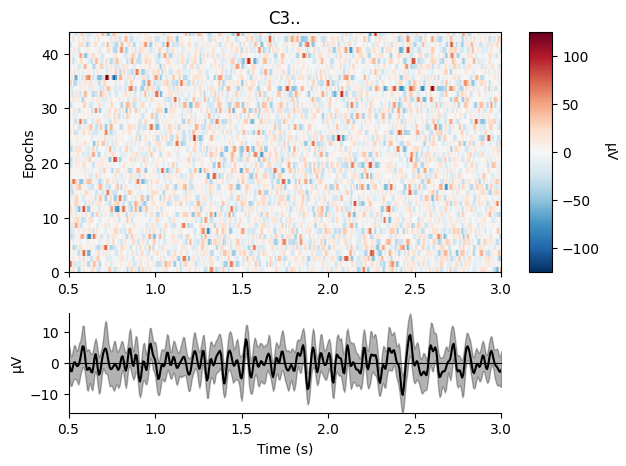

[<Figure size 640x480 with 3 Axes>]

In [10]:
print("Condições: ",subject_epochs.event_id)
print("\nBlocos: ",subject_epochs.events)
subject_epochs["right_fist"].plot_image(picks=[chan[0]])

In [11]:
print("Dados de um sujeito [Trials, Elétrodos, Amostras] =",np.shape(subject_epochs.get_data()))

Dados de um sujeito [Trials, Elétrodos, Amostras] = (220, 64, 401)


## **Dados Train/Test**

In [12]:
def split_EEG(subject_EEG, classes, percent_train=0.8):
  
  n_trials, _, _ = np.shape(subject_EEG)
  n_train = round((n_trials/len(classes)) * percent_train)
  n_test = int((n_trials/len(classes)) - n_train)

  print("Nº de trials: ", n_trials)
  print("Nº de trials para treinar (por classe): ", n_train)
  print("Nº de trials para teste (por classe): ", n_test)

  epochs_train = []
  epochs_test = []

  for class_key, _ in classes.items():
    epochs_train.append(subject_EEG[class_key][:n_train])
    epochs_test.append(subject_EEG[class_key][n_train:n_train+n_test])
  
  epochs_train = mne.concatenate_epochs(epochs_train, add_offset = True, on_mismatch = 'raise')
  epochs_test = mne.concatenate_epochs(epochs_test, add_offset = True, on_mismatch = 'raise')

  return epochs_train, epochs_test

# Split Test/Train

classes = subject_epochs.event_id

all_train_data = []
all_test_data = []

for subject in range(len(all_subject_epochs)):
  print(subject)
  train_data, test_data = split_EEG(all_subject_epochs[subject], classes, percent_train=0.8)
  all_train_data.append(train_data)
  all_test_data.append(test_data)

0
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
1
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
2
Nº de trials:  215
Nº de trials para treinar (por classe):  34
Nº de trials para teste (por classe):  9
3
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
4
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
5
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
6
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
7
Nº de trials:  220
Nº de trials para treinar (por classe):  35
Nº de trials para teste (por classe):  9
8
Nº de trials:  215
Nº de trials para treinar (por classe):  34
Nº de trials para teste (por classe):  9
9
Nº de trials:  210
Nº de trials para treinar

✅

## **Obtenção do filtro espacial (unmixing matrix) a partir do algoritmo Common Spatial Patterns (CSP)**

* Algoritmo aplicado de raiz

In [13]:
import numpy as np
from numpy import linalg
from scipy.linalg import sqrtm
from scipy.linalg import inv

# Matrizes das covariâncias:

def covariances(epoched_data):

  '''
  Cálculo das matrizes de covariância para cada classe
  '''

  classes = epoched_data.event_id
  n_trials, n_channels, n_samples = np.shape(epoched_data)
  n_trials = int(n_trials/len(classes))
  Trials_convs = np.zeros((n_trials, n_channels, n_channels))
  Class_convs = np.zeros((len(classes), n_channels, n_channels)) 
  # Pré alocação da variável 'convs'. Isto é boa prática fazer antes de qualquer ciclo para reduzir o tempo de processamento pré-alocando o array na memória.
  
  for mi_class, id in classes.items(): # Iteração de um dicionário
  
    Xc = epoched_data[mi_class].get_data()
    for trial in range(n_trials):
      Trials_convs[trial,:,:] = (Xc[trial,:,:] @ Xc[trial,:,:].T) / (np.trace (Xc[trial,:,:] @ Xc[trial,:,:].T)) # Cálculo das Covariâncias com normalização ap aprtir do traço da matriz
    Class_convs[id-1,:,:] = np.mean(Trials_convs, axis = 0) # Média dos trials da mesma classe
    
  return Class_convs

# Whitening da matriz, ou seja, transformação que permite com que a matriz tenha a mesma covariância da matriz Identidade (I), 
# logo covariâncias de 0 entre todos os pares:

def decompose_cov(avg_cov):

    λ, V = np.linalg.eig(avg_cov) # λ são o eigenvalues e V os eigenvectors
    λ_desc = np.sort(λ)[::-1] 
    idx_desc = np.argsort(λ)[::-1] 
    V_desc = V[:, idx_desc] 
    λ_desc = np.diag(λ_desc) 
    
    return λ_desc, V_desc

def whitening(λ_desc, V_desc):

    λ_desc_sqr = sqrtm(inv(λ_desc))
    P = (λ_desc_sqr) @ (V_desc.T)
    
    return P

# Matriz S que contém os eigenvectors que maximizam a variância do EEG (freq) numa classe e minimiza noutra:

def compute_S(avg_Cov, white):
    
    S = white @ avg_Cov @ white.T
 
    return S

def decompose_S(S_one_class, order='d'):
  
    λ, B = np.linalg.eig(S_one_class)
    
    if order == 'a': # ascending
        idx = λ.argsort() 
    elif order == 'd': # descending
        idx = λ.argsort()[::-1] 
    else:
        print('Wrong order input')
    
    λ = λ[idx]
    B = B[:, idx]
    
    return B, λ 

# One-vs-the-rest CSP, ou seja, uma classe contra a contribuição conjunta de todas as outras:
# Filtro espacial (Matriz de projeção):

  # B_one_class = np.zeros( (len(classes),len(subject_epochs.get_channel_types())) )
  # B_the_rest_classes = np.zeros( (len(classes),len(subject_epochs.get_channel_types())) )

def spatial_filter(B, P):

    return (B.T @ P)
    

In [14]:
all_W = []

for subject in range(len(all_train_data)):

  Class_convs = covariances(all_train_data[subject])
  Avg_convs = Class_convs.sum(axis = 0)
  λ_desc, V_desc = decompose_cov(Avg_convs)
  P = whitening(λ_desc, V_desc)
  W = np.zeros( (len(classes), n_channels, n_channels) )

  for _, id in classes.items(): 

    one = compute_S(Class_convs[id-1,:,:], P)
    the_rest = compute_S(  np.sum(Class_convs[:(id-1),:,:], axis = 0) + np.sum(Class_convs[id:,:,:], axis = 0)  , P)

    λ_one, B_one = decompose_S(one, 'd')
    λ_the_rest, B_the_rest = decompose_S(the_rest, 'a')
    
    W[id-1,:,:] = spatial_filter(λ_one, P) 
    
    #print("Eigenvalues: ", B_one + B_the_rest)
  
  all_W.append(W)

* Os eigenvalues deram todos 1, logo está ✅



## **Filtrar espacialmente o EEG com a matriz W (unmixing matrix) para extração de features**

In [15]:
def spatially_filter_EEG(W, EEG, n_comp):

    Z = []
    
    W = np.delete(W, np.s_[n_comp:-n_comp:], 0)

    for trial in range(len(EEG.events)):
      Z.append( W @ np.squeeze(EEG[trial].get_data()) )

    return np.array(Z)

def feat_vector(Z):
    
    feat = []
    
    for i in range(Z.shape[0]):
        var = np.var(Z[i], ddof=1, axis=1)
        varsum = np.sum(var)
        
        feat.append(np.log10(var/varsum))
        
    return np.array(feat)


* A variável 'n_comp' é um parâmetro importante no contexto do CSP. A unmixing matrix (W) contém o nº de componentes que permitem separar duas classes de movimentos.

* O 'n_comp' seleciona o nº de componenentes (igual ao nº de elétrodos, daí a ser um filtro espacial) de cada classe que irá ser usado para separar as classes, ou seja, maximizar a variância de uma classe e minimizar a variância da outra.


In [16]:
all_feat_classes_train = []
all_feat_classes_test = []

n_comp = 6

for subject in range(len(all_subject_epochs)):

  feat_classes_train = []
  feat_classes_test = []

  for mi_class, c_id in classes.items():
    Z_aux_train = spatially_filter_EEG(all_W[subject][c_id-1,:,:], all_train_data[subject][mi_class], n_comp)
    feat_classes_train.append(feat_vector(Z_aux_train)) 

    Z_aux_test = spatially_filter_EEG(all_W[subject][c_id-1,:,:], all_test_data[subject][mi_class], n_comp)
    feat_classes_test.append(feat_vector(Z_aux_test)) 

  all_feat_classes_train.append(feat_classes_train)
  all_feat_classes_test.append(feat_classes_test)


## **Classificação**

### **Treino**

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score

clf = LDA()
cross_val_scores = np.zeros((len(all_subject_epochs),2))
kfold = 10
test_labels=[]
test=[]

for subject in range(len(all_subject_epochs)):

  X_train = np.reshape(all_feat_classes_train[subject], (-1,n_comp * 2))
  X_test = np.reshape(all_feat_classes_test[subject], (-1,n_comp * 2))

  y_train = all_train_data[subject].events[:,2].reshape(-1,1)
  y_test = all_test_data[subject].events[:,2].reshape(-1,1)

  train = np.concatenate((X_train,y_train), axis = 1)
  test.append(np.concatenate((X_test,y_test), axis = 1))

  np.random.shuffle(train)
  np.random.shuffle(test[subject])

  # Perform cross-validation on train data with LDA classifier
  scores = cross_val_score(clf, train[:,0:n_comp * 2], train[:,n_comp * 2], cv=kfold)

  # Fit the LDA classifier on the entire train dataset
  clf.fit(train[:,0:n_comp * 2], train[:,n_comp * 2])

  # Predict the target classes for test dataset
  test_labels.append(clf.predict(test[subject][:,0:n_comp * 2]))
 
  cross_val_scores[subject,0] = (scores.mean() * 100)
  cross_val_scores[subject,1] = ((scores.std() * 2) * 100)

  #print("Acuracia (Cross-validation) do participante %d: %0.2f (+/- %0.2f)" % (subject+1, cross_val_scores[subject,0], cross_val_scores[subject,1]))

print("\n")
print("Média de acuracia (Cross-validation): %0.2f (+/- %0.2f) " % (np.mean(cross_val_scores[:,0]), np.mean(cross_val_scores[:,1])))



Média de acuracia (Cross-validation): 51.31 (+/- 20.35) 


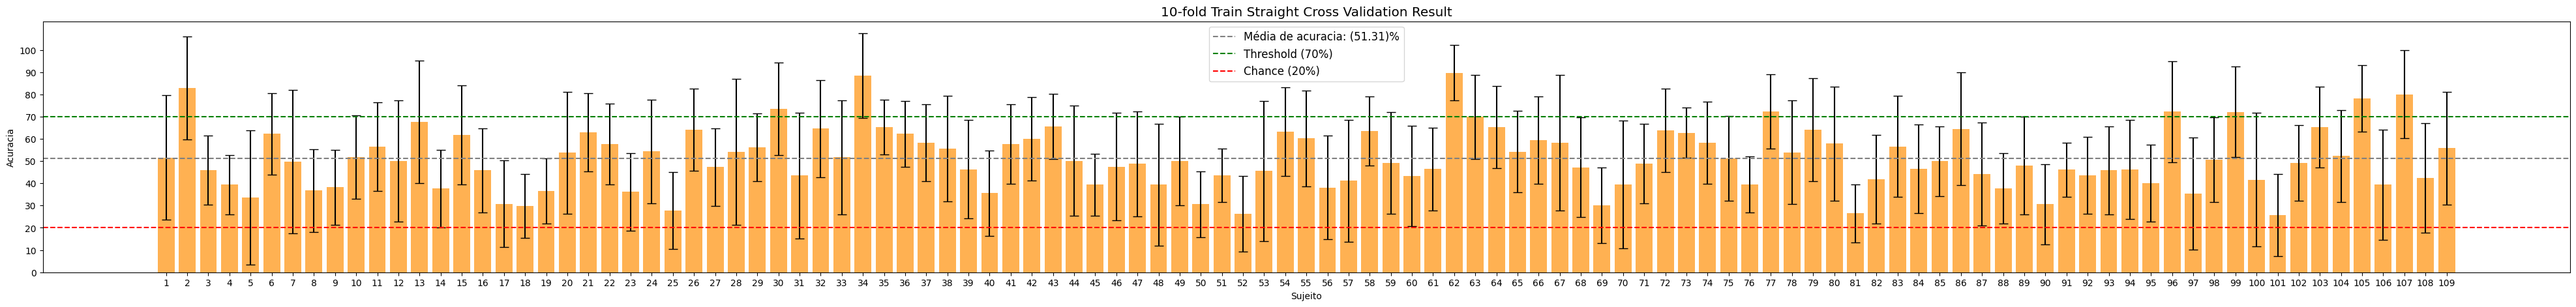

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(50, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title('Acuracia (%)')
ax.bar(np.arange(1, len(all_subject_epochs)+1), cross_val_scores[:,0], color="#ffb152", yerr=cross_val_scores[:,1], capsize=5)
ax.axhline(y=np.mean(cross_val_scores[:,0]), color='grey', linestyle='--', label = f'Média de acuracia: ({np.mean(cross_val_scores[:,0]):.2f})%')
ax.axhline(y=70, color='green', linestyle='--', label = 'Threshold (70%)')
ax.axhline(y=20, color='red', linestyle='--', label = 'Chance (20%)')
ax.set(xticks=np.arange(1, len(all_subject_epochs)+1), xlabel='Sujeito', 
       yticks=np.arange(0, 101, step=10), ylabel='Acuracia',
       title='10-fold Train Straight Cross Validation Result');
ax.legend();


### **Teste**

In [20]:
from sklearn.metrics import accuracy_score

all_acc = np.zeros(len(all_subject_epochs))

for subject in range(len(all_subject_epochs)):

  acc = accuracy_score(test[subject][:,n_comp * 2],test_labels[subject]) * 100
  all_acc[subject] = acc 

  #print("Acuracia do participante %d: %0.2f " % (subject+1, acc))


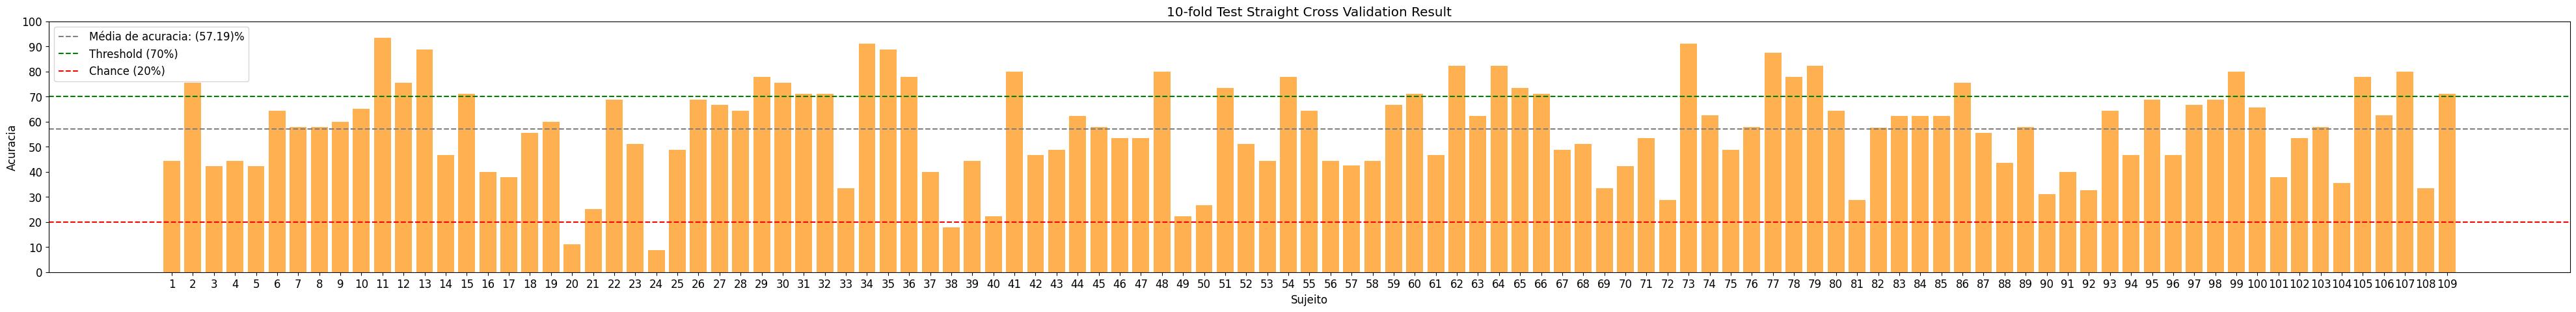

In [21]:
fig, ax = plt.subplots(figsize=(50, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title('Acuracia (%)')
ax.bar(np.arange(1, len(all_subject_epochs)+1), all_acc, color="#ffb152", capsize=5)
ax.axhline(y=np.mean(all_acc), color='grey', linestyle='--', label = f'Média de acuracia: ({np.mean(all_acc):.2f})%')
ax.axhline(y=70, color='green', linestyle='--', label = 'Threshold (70%)')
ax.axhline(y=20, color='red', linestyle='--', label = 'Chance (20%)')
ax.set(xticks=np.arange(1, len(all_subject_epochs)+1), xlabel='Sujeito', 
       yticks=np.arange(0, 101, step=10), ylabel='Acuracia',
       title='10-fold Test Straight Cross Validation Result');
ax.legend();

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = test[:,n_comp * 2]
y_pred = test_labels
C=confusion_matrix(y_true, y_pred)
print(C)
print(C / C.astype(np.float).sum(axis=1));
